# **INTELIGENCIA DEL NEGOCIO / Business Intelligence**
## **ASSIGNMENT A1 - MULTILAYER PERCEPTRON**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación, etc.
- Recuerda poner nombre a todas las layers de Keras, facilitará mucho las cosas a la hora de depurar errores.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya amplíandolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 05/02/2024**
- **Fecha de Entrega: 11/02/2024**
- **Test: 12/02/2024**


### Autores: 
* Yago Tobio Souto (201802168)
* Luis Bueno Archaga (201810661)

# Carga de librerías

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
import sklearn
random.seed(0)

In [5]:
print("TF VERSION: ", tf.__version__)
print("SKLEARN VERSION: ", sklearn.__version__)
print("PANDAS VERSION: ", pd.__version__)
print("MATPLOTLIB VERSION: ", sklearn.__version__)

TF VERSION:  2.15.0
SKLEARN VERSION:  1.3.2
PANDAS VERSION:  2.1.3
MATPLOTLIB VERSION:  1.3.2


# Carga dataset

Se va a usar un dataset que contiene información socieconómica de ciudadanos americanos.

Queremos construir un modelo que realice predicciones a partir de estas features, utilizando la variable "income" como salida al modelo, la cual indica si la persona tiene unos ingresos superiores o inferirores a 50K. Es por tanto un problema de clasificación binaria.

Puede ver descripciones de los datos en el siguiente link:

https://archive.ics.uci.edu/ml/datasets/census+income

El dataset es muy grande, vamos a tomar solamente algunas de sus muestras.

In [6]:
# ? - Si se corre en Google Colab
#from google.colab import drive
#drive.mount('/content/drive')
#pd_data = pd.read_csv("/content/drive/MyDrive/BI/income_evaluation.csv").sample(5_000)

In [7]:
# ? - Si se corre en Local
pd_data = pd.read_csv("income_evaluation.csv").sample(5_000)

In [8]:
for c in pd_data.columns:
    pd_data = pd_data.rename(columns={c: c.replace(" ", "")})

In [9]:
TARGET = "income"
NUMERICAL_COLUMNS = ["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]
CATEGORICAL_COLUMNS = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

Divida el dataset en train y test. Un 20% en test puede ser suficiente.

In [10]:
pd_train, pd_test = sklearn.model_selection.train_test_split(pd_data, test_size=0.2, shuffle=True)

In [11]:
print("SAMPLES TRAIN: ", len(pd_train))
print("SAMPLES TEST: ", len(pd_test))

SAMPLES TRAIN:  4000
SAMPLES TEST:  1000


# Analisis

- Histogramas de las variables numéricas

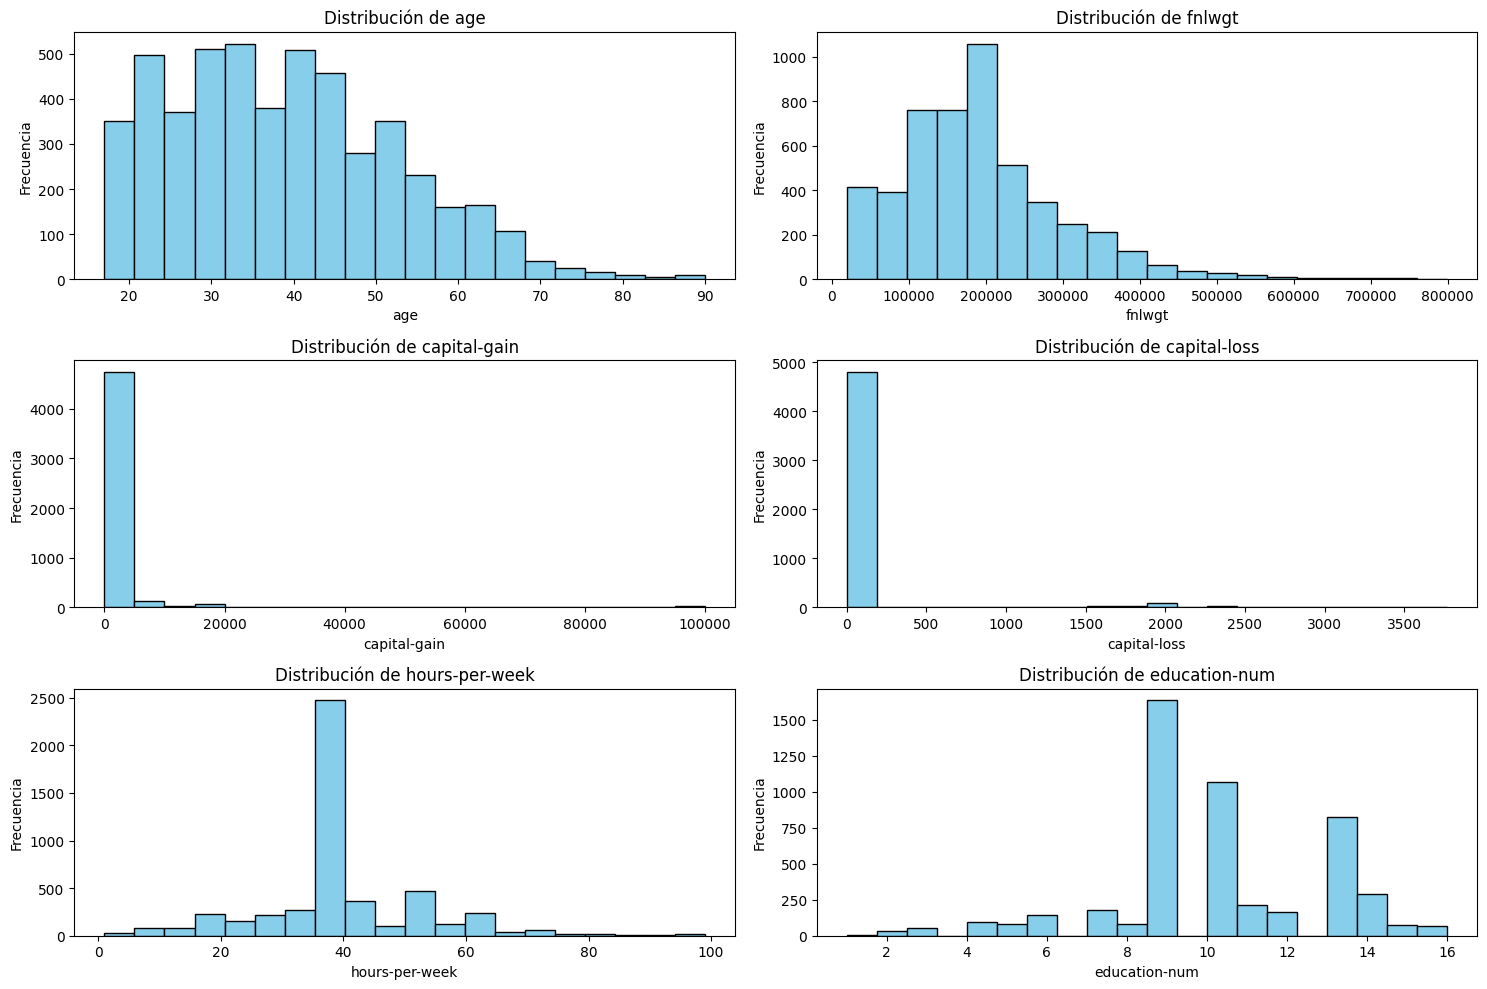

In [12]:
# Configurar el tamaño de la figura para acomodar todos los histogramas
plt.figure(figsize=(15, 10))

# Crear un histograma para cada columna numérica
for i, column in enumerate(NUMERICAL_COLUMNS, 1):
    plt.subplot(3, 2, i)  # 3 filas, 2 columnas, posición i
    plt.hist(pd_data[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

# Ajustar el layout para evitar la superposición
plt.tight_layout()
plt.show()

- Histogramas de las variables categóricas

## ¿Que observamos aquí?


*   La distribución de la edad es normal, y esta centrada alrededor de los 30 - 35 años, lo cual tiene sentido. Ya que la media de la población comienza a trabajar alrededor de los 20 año.
*   fnlwgt - No tiene descripción en la página web adjunta pero en este tipo de datasets se define como: "Final Weight" . Es una metrica la cual sirve para reflejar la distribución demográfica de manera precisa. Lo cual tiene sentido que muestre una distribución normal descentrada.
* Para capital-gain y capital-loss las cuales indican los beneficios y perdidas generadas al vender o intercambiar activos, directamente no tienen una gran distribución.
  * Para Capital Gains observamos, que las ganancias se encuentran en un rango menos a los 100.000 dolares. Con la breve excepción de 100.000, al final del dataset.
  * Para Capital Loss, observamos, que es mucho más conservador. Es decir, que la población no ha perdido tanto dinero. Ya que Capital Loss principalmente se encuentra en el rango de los cienes de euros. Lo cual ya nos indica que esta población ha sacado rentabilidad neta en el caso de intercambio de activos.
* Para la distribución de horas trabajadas a la semana. Podemos observar una fuerte media de entre 35 y 40 horas.
* Para el número de años de formación, observamos que la media va en torno a los 9 y 10 años. Pero no es una distribución muy uniforme.


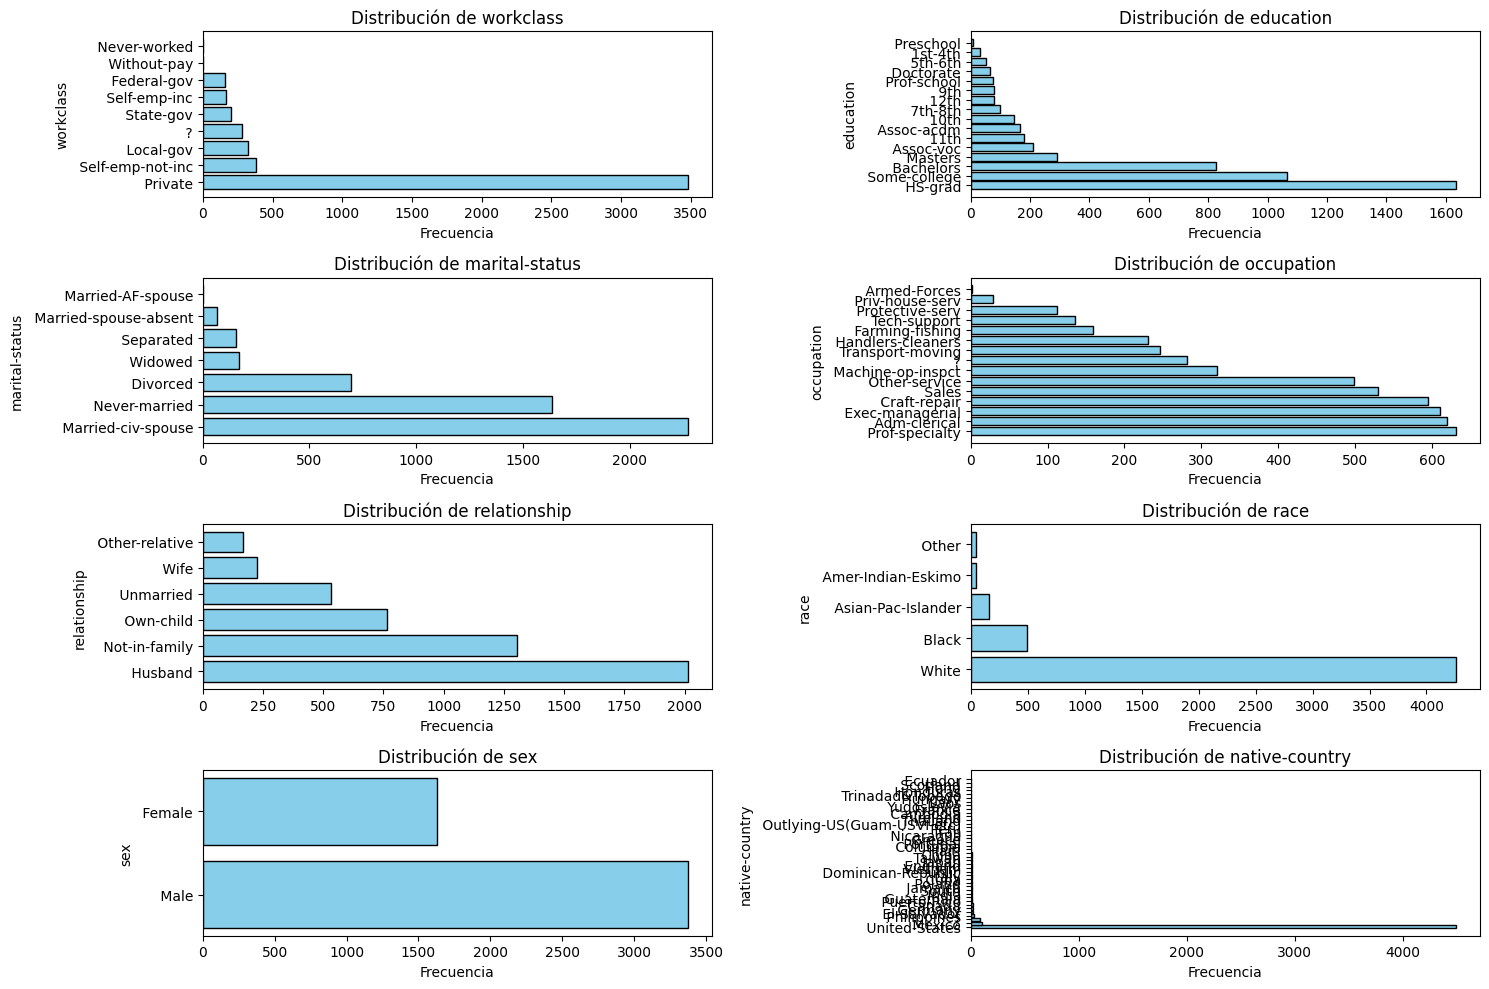

In [13]:
 
# ? - Mucho más claro. Al ser variables categoricas, cuadra más hacer un bar chart que un histograma. 
# ? - De paso prevenimos sobrelapamiento de las etiquetas. 
plt.figure(figsize=(15, 10))

for i, column in enumerate(CATEGORICAL_COLUMNS, 1):
    # Calculate the frequencies of each category
    value_counts = pd_data[column].value_counts()
    
    # Create a horizontal bar chart
    plt.subplot(4, 2, i)  # Adjust the grid dimensions as needed
    plt.barh(value_counts.index, value_counts, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel('Frecuencia')
    plt.ylabel(column)
    
    # If there's a lot of categories, you might not need to rotate the y-tick labels, but adjust if necessary
    # plt.yticks(rotation=45)  # Uncomment if needed
plt.tight_layout()
plt.show()


**¿Que podemos observar?**
*Considerando que el dataset es de 1996, podemos observar los siguientes atributos.*



*   La gran mayoría de participantes trabajan para una empresa en el sector privado.
*   La mayoría llegaron a hacer el insituto (High School), la carrera, o algún tipo de certificado. Con un porcentaje pequeño alcanzando el Master o el Doctorado.
* El dataset es equilibrado al incorporar gente casada, sin pareja y divorciados.
* Igualmente el tipo de trabajo es muy variado, lo cual muestra diversidad de oficio en el dataset.
* En cambio, hay muchos más hombres que mujeres en el dataset, donde la gran mayoría son blancos y cuyo país de origen son los Estados Unidos.



- Evaluar la Correlación entre variables numéricas


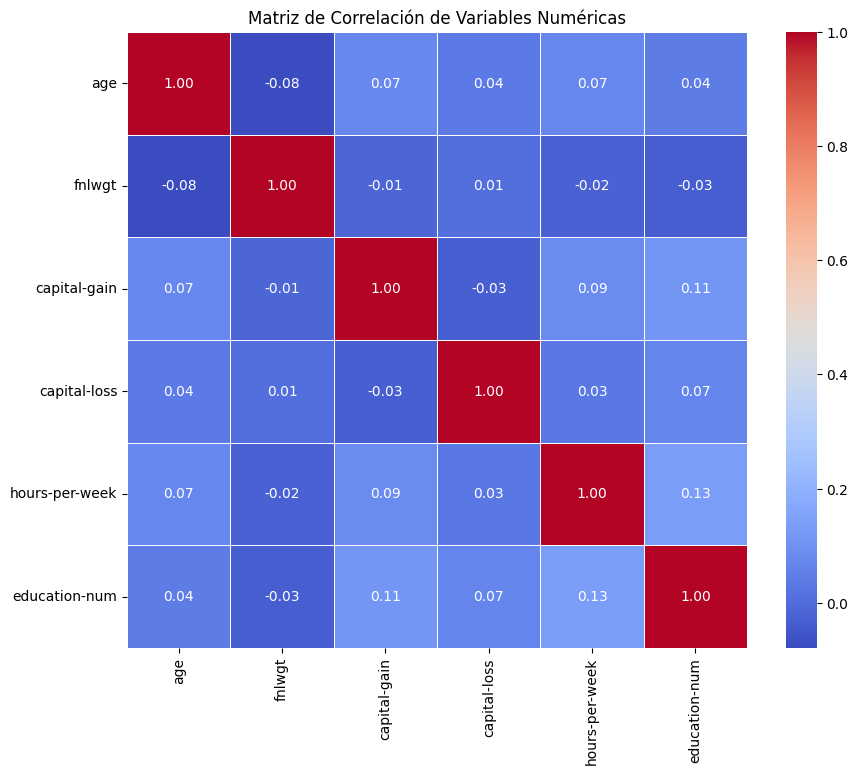

In [14]:
# Calcular la matriz de correlación de las variables numéricas
correlation_matrix = pd_data[NUMERICAL_COLUMNS].corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Generar un mapa de calor para la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

*Se puede apreciar al mostrar el mapa de correlación entre las variables, que entre las variables continuas, no aparenta haber ningún tipo de correlación fuerte.*

- Evaluar la importancia de las variables categóricas

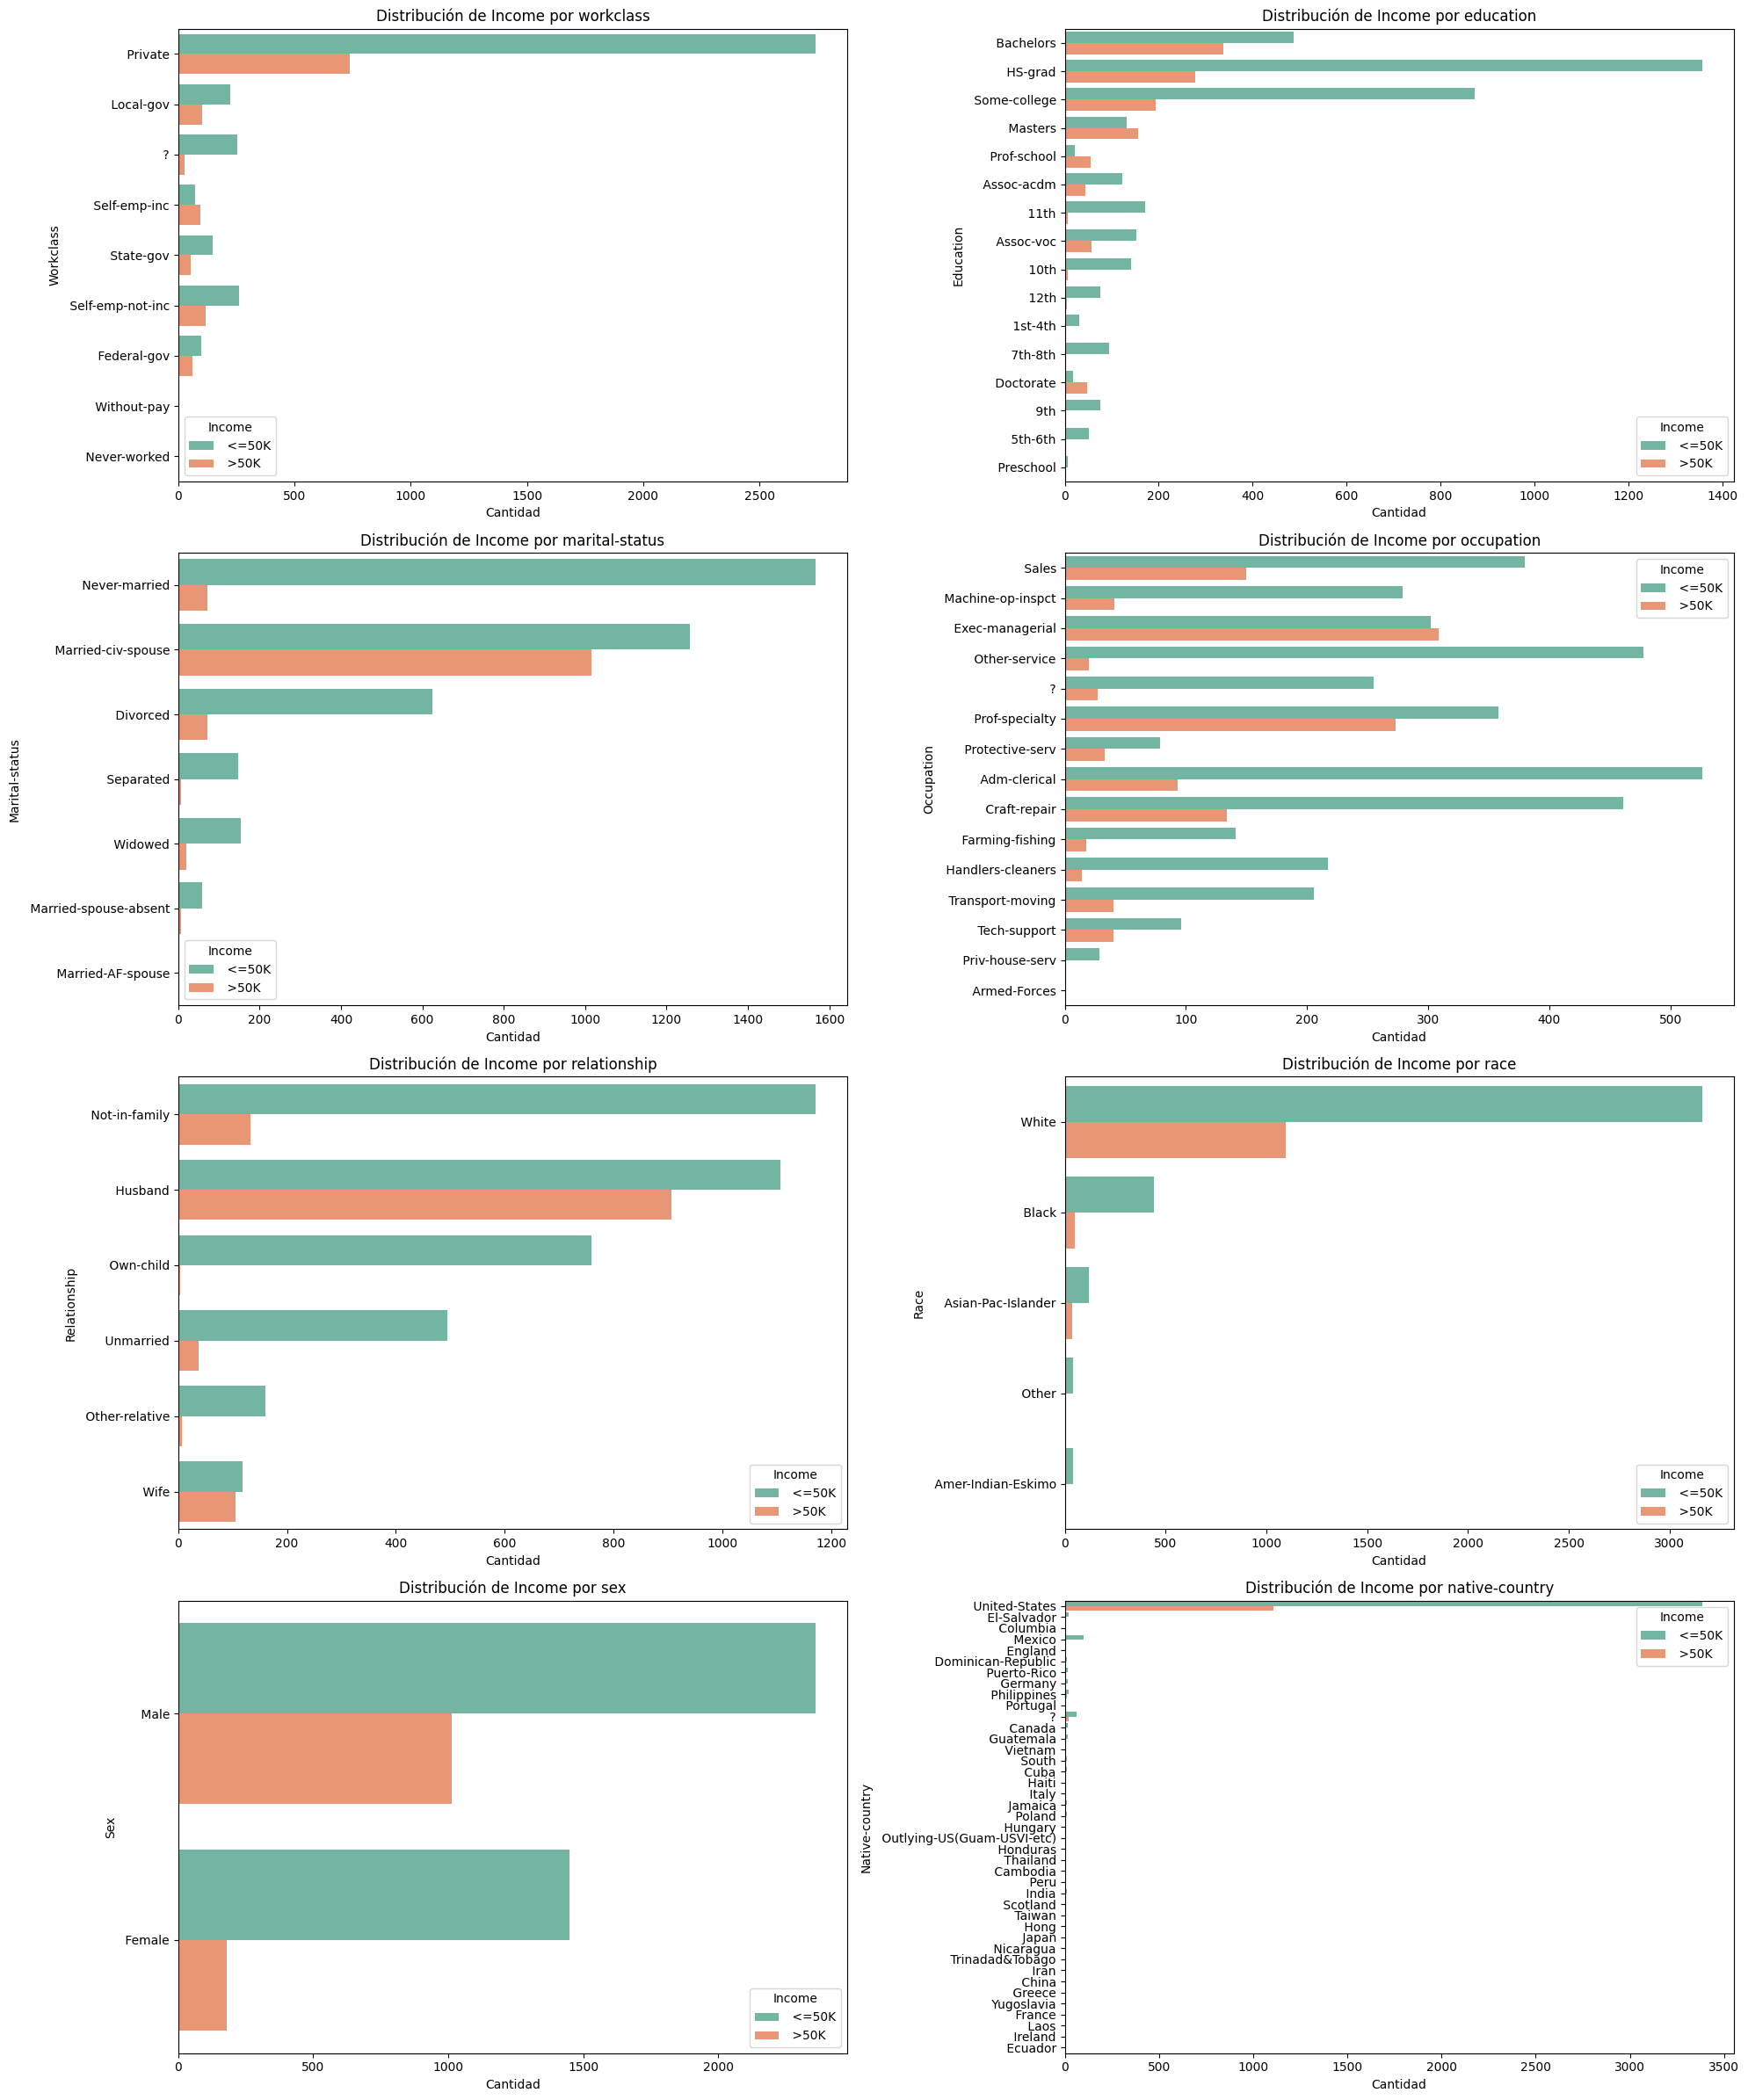

In [15]:
# Configurar el tamaño de la figura para acomodar todos los subplots
plt.figure(figsize=(20, 24))

# Crear un subplot para cada variable categórica
for i, column in enumerate(CATEGORICAL_COLUMNS, 1):
    plt.subplot(4, 2, i)  # Organizar en 4 filas y 2 columnas
    sns.countplot(y=column, hue='income', data=pd_data, palette='Set2')
    plt.title(f'Distribución de Income por {column}')
    plt.xlabel('Cantidad')
    plt.ylabel(column.capitalize())
    plt.legend(title='Income')

# Ajustar el layout para evitar la superposición
plt.tight_layout()

# Mostrar el gráfico
plt.show()



- En las variables categóricas, tomar aquellas etiquetas con baja volumetría y unirlas en un etiqueta default.

In [16]:
# Definir el umbral para considerar baja volumetría (ejemplo: menos del 5% del total)
umbral = 0.05

# Copiar el dataframe para evitar modificar el original
data_updated = pd_data.copy()

# Procesar cada variable categórica
for column in CATEGORICAL_COLUMNS:
    # Calcular la frecuencia relativa de cada categoría
    freq = pd_data[column].value_counts(normalize=True)

    # Identificar las categorías con baja volumetría
    categories_to_replace = freq[freq < umbral].index

    # Reemplazar las etiquetas de baja volumetría por 'default'
    pd_data[column] = pd_data[column].apply(lambda x: 'default' if x in categories_to_replace else x)

# Preprocesado del target

Aplique una trasformación en el target para convertirlo en unos y ceros.

In [17]:
pd_data['income_binary'] = pd_data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Verificar los cambios en el target
pd_data['income_binary'].value_counts()

pd_train, pd_test = sklearn.model_selection.train_test_split(pd_data, test_size=0.2, shuffle=True)

# Preprocesado de las variables numéricas

Vamos a comenzar construyendo un modelo usando solo variables numéricas ya que son las más sencillas de tratar. Para empezar, aplique una transformación en las features para normalizarlas a media cero y desviación típica uno.

In [18]:
scaler = StandardScaler()

# Ajustar y transformar los datos numéricos
data_normalized = scaler.fit_transform(pd_data[NUMERICAL_COLUMNS])

# Crear un DataFrame con los datos normalizados
data_normalized_df = pd.DataFrame(data_normalized, columns=NUMERICAL_COLUMNS)

# Mostrar las primeras filas para verificar la transformación
print(data_normalized_df.head())

        age    fnlwgt  capital-gain  capital-loss  hours-per-week  \
0 -1.153796 -1.333941     -0.152707      4.006418       -2.321703   
1 -0.203508 -0.890586     -0.152707     -0.201316        0.368661   
2  0.161988 -0.224843     -0.152707     -0.201316        0.368661   
3 -0.788300 -1.494704     -0.152707     -0.201316       -0.446600   
4  1.697068  1.805159     -0.152707     -0.201316       -3.136964   

   education-num  
0       1.128822  
1      -0.417721  
2      -0.417721  
3      -0.031086  
4       1.515457  


# Modelo baseline de variables continuas

Construya una regresión logística a partir de las features transformadas. Use el dataset de test para evaluar el modelo y calcule el accuracy, precision, recall, f1 y área bajo la curva. ¿Cuál crees que es la mejor métrica para evaluar este problema?

In [19]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
X = data_normalized_df  # Características normalizadas
y = pd_data['income_binary']  # Target ya transformado a binario

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nf1-score: {f1}\nroc_auc: {roc_auc}")

Accuracy: 0.829
Precision: 0.6824324324324325
Recall: 0.4488888888888889
f1-score: 0.5415549597855228
roc_auc: 0.6941218637992832


Dado que el problema implica clases desbalanceadas y la tarea es predecir ingresos (potencialmente con un interés particular en identificar correctamente los ingresos altos, que podrían constituir una clase minoritaria), ROC_AUC y f1-score emergen como las métricas más informativas y equilibradas para evaluar el rendimiento del modelo.

* ROC_AUC es útil porque proporciona una visión general del rendimiento del modelo en diferentes umbrales, lo cual es valioso en conjuntos de datos desbalanceados.
* F1-Score ofrece un equilibrio entre precision y recall, siendo particularmente relevante cuando es importante tanto minimizar los falsos positivos como los falsos negativos.


# Modelo Deep Learning

Construya un perceptrón multicapa para predecir el target.

In [ ]:

# ? - Versión del profe
HIDDEN_SIZES = [10, 3]
# * Input - De X
inputs = tf.keras.layers.Input(shape=(X_train.shape[-1], ), name="numeric_input")
x = inputs
# * - Definimos las dos capas ocultas con numero de neuronas 10 y 3
for i, h in enumerate(HIDDEN_SIZES):
    x = tf.keras.layers.Dense(h, activation="relu", name=f"hidden_layer_{i+1}")(x)
# * - Ultima capa
y = tf.keras.layers.Dense(1, activation="sigmoid", name="last_layer")(x)
numeric_model = tf.keras.models.Model(inputs, y, name="continuos_model")
numeric_model.summary()

In [20]:
# Construir el modelo
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta con 32 neuronas
    Dense(16, activation='relu'),  # Otra capa oculta con 16 neuronas
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoid para clasificación binaria
])

# Compilar el modelo
# TODO - El profesor definió cual era el learning rate A LA HORA DE COMPILAR EL MODELO 
# TODO - y para metricas incluyó accuracy, recall, precision, AUC
# ? numeric_model.compile(tf.keras.optimizers.Adam(learning_rate=5e-3), loss="binary_crossentropy",
# ?                      metrics=["accuracy", tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"),
# ?                              tf.keras.metrics.AUC(name="auc")])

model.compile(optimizer=Adam(),  # Optimizador Adam
              loss='binary_crossentropy',  # Función de pérdida para clasificación binaria
              metrics=['accuracy'])  # Métricas para evaluar el modelo

# Entrenar el modelo
# TODO - El profesor cogió un batch de 128 y por lo tanto un número de EPOCHS menor de 35
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/100


100/100 [==============================] - 1s 2ms/step - loss: 0.5617 - accuracy: 0.7341 - val_loss: 0.4483 - val_accuracy: 0.8062
Epoch 2/100
100/100 [==============================] - 0s 854us/step - loss: 0.4156 - accuracy: 0.8109 - val_loss: 0.3959 - val_accuracy: 0.8225
Epoch 3/100
100/100 [==============================] - 0s 848us/step - loss: 0.3943 - accuracy: 0.8222 - val_loss: 0.3872 - val_accuracy: 0.8213
Epoch 4/100
100/100 [==============================] - 0s 800us/step - loss: 0.3876 - accuracy: 0.8250 - val_loss: 0.3839 - val_accuracy: 0.8250
Epoch 5/100
100/100 [==============================] - 0s 765us/step - loss: 0.3839 - accuracy: 0.8253 - val_loss: 0.3814 - val_accuracy: 0.8275
Epoch 6/100
100/100 [==============================] - 0s 794us/step - loss: 0.3810 - accuracy: 0.8234 - val_loss: 0.3811 - val_accuracy: 0.8213
Epoch 7/100
100/100 [==============================] - 0s 847us/step - loss: 0.3786 - accuracy: 0.8266 - val_loss: 0.3815 - val_accuracy: 0.8188

Training Accuracy: 82.75%

Test Accuracy: 81.2%

No se sufre de sobre-ajuste.

In [ ]:
 # TODO - El profesor al haber incluido más metricas de precisión ha hecho un plot de error: 
metrics = [m for m in history.history.keys() if "val_" not in m]
fig, axs = plt.subplots(int(np.ceil(len(metrics) / 2)), 2, figsize=(20, 10))
for ax, m in zip(axs.flatten(), metrics):
    ax.plot(history.history[m], label="train")
    ax.plot(history.history["val_" + m], label="val")
    ax.set_title(m)
    ax.legend()
    ax.grid()

# TODO - Accuracy, Recall, Precision, etc... 
print("TEST ACCURACY: ", sklearn.metrics.accuracy_score(y_test, predictions_test))
print("TEST RECALL: ", sklearn.metrics.recall_score(y_test, predictions_test))
print("TEST PRECISION: ", sklearn.metrics.precision_score(y_test, predictions_test))
print("TEST F1: ", sklearn.metrics.f1_score(y_test, predictions_test))
print("TEST AUC", sklearn.metrics.roc_auc_score(y_test, predictions_proba_test))

Al haber incluido el learning rate, debemos de encontrar la manera optima del learning rate. 

In [ ]:
 # TODO - El profesor ha incluido el parametro del learning rate para observar su punto optimo 
# * Modify learning rate and observe through plots how it improves
from tensorflow import keras
def reinitialize_model(model):
    weights = []
    initializers = []
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
            weights += [layer.kernel, layer.bias]
            initializers += [layer.kernel_initializer, layer.bias_initializer]
        elif isinstance(layer, keras.layers.BatchNormalization):
            weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
            initializers += [layer.gamma_initializer,
                           layer.beta_initializer,
                           layer.moving_mean_initializer,
                           layer.moving_variance_initializer]
    for w, init in zip(weights, initializers):
        w.assign(init(w.shape, dtype=w.dtype))
reinitialize_model(numeric_model)

In [ ]:
plt.figure(figsize=(10, 5))
for h, lr in zip(histories, learning_rates):
    plt.plot(h.history["val_loss"], label=f"log(lr) = {np.log10(lr):.2f}")
plt.grid()
plt.legend()

## Construcción del modelo
Construye el modelo con Keras. Utilice varias capas (entre 1 y 2 serán suficiente). Puede probar varios valores para el número de capas y el tamaño de las mismas. Considere añadir capas de Dropout entre algunas (o todas) las capas.

In [21]:
# Inicializar el modelo secuencial
model = Sequential()

# Añadir la primera capa oculta con Dropout
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))  # 50% de Dropout

# Añadir la segunda capa oculta con Dropout
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))  # 50% de Dropout

# Añadir la capa de salida - Sigmoid para clasificación binaria
model.add(Dense(1, activation='sigmoid'))


## Compilación del modelo
Compile el modelo con adam como función de optimización. Elija la función de pérdida acorde con el objetivo que buscamos. Además, elija algunas métricas que nos permitan evaluar el modelo.

In [22]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

# Mostrar el resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2561 (10.00 KB)
Trainable params: 2561 (10.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entrenamiento

Entrene el modelo. Elija el tamaño del batch y el número de epochs necesario. Utilice algunas de las técnicas mencionadas en clase para evitar el overfitting del modelo.

Early Stopping:
Es un callback que nos da Keras que supervisa el rendimiento del modelo sobre un dataset de validación durante el entrenamiento. Si el rendimiento no mejora secuencialmente al incrementar el número de Epochs, se para el entrenamiento.

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100


100/100 [==============================] - 0s 2ms/step - loss: 0.6347 - auc: 0.6054 - val_loss: 0.4883 - val_auc: 0.7868
Epoch 2/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4770 - auc: 0.7576 - val_loss: 0.4063 - val_auc: 0.8325
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4403 - auc: 0.8045 - val_loss: 0.3934 - val_auc: 0.8374
Epoch 4/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4384 - auc: 0.8030 - val_loss: 0.3890 - val_auc: 0.8414
Epoch 5/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4298 - auc: 0.8103 - val_loss: 0.3850 - val_auc: 0.8445
Epoch 6/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4174 - auc: 0.8225 - val_loss: 0.3846 - val_auc: 0.8435
Epoch 7/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4209 - auc: 0.8203 - val_loss: 0.3829 - val_auc: 0.8446
Epoch 8/100
100/100 [==============================] - 0s 997us/step - loss: 0.41

El método fit devuelve un objeto de tipo history con las métricas obtenidas durante el entrenamiento. Analice el resultado de ejecutar 'history.history' y dibuje las métricas en las distintas épocas.

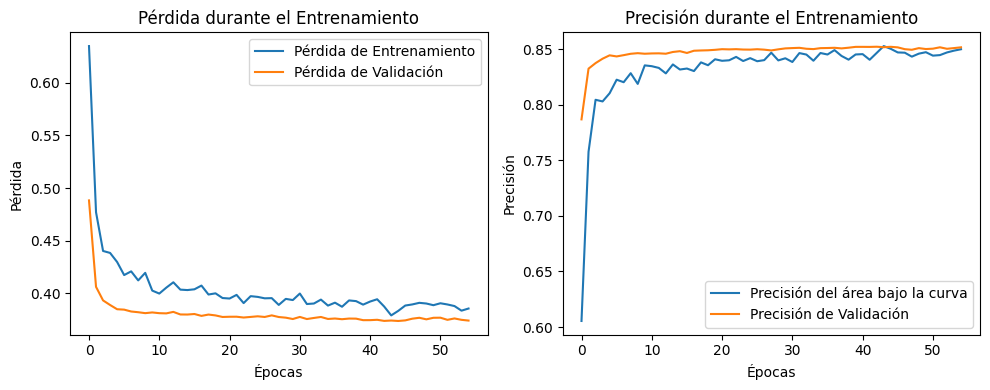

In [24]:
# Suponiendo que 'history' es el objeto retornado por model.fit()
metrics = history.history

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['loss'], label='Pérdida de Entrenamiento')
plt.plot(metrics['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la auc de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(metrics['auc'], label='Precisión del área bajo la curva')
plt.plot(metrics['val_auc'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


Se puede observar que aunque el modelo se entrenase con 100 Epochs, el sistema de ***Early Stopping***, decidió parar el entrenamiento tras el Epoch 65+ debido a que ya no había ninguna perdida adicional.

## Evaluación

Utilice el dataset de test para conseguir las métricas que se calcularon con el modelo baseline. Compare los resultados con el baseline.

In [25]:
# Aplicar un umbral de decisión de 0.5 para convertir las predicciones continuas en binarias
y_pred_baseline_binary = (y_pred > 0.5).astype(int)

# Evaluar el modelo baseline con predicciones binarias
accuracy_baseline = accuracy_score(y_test, y_pred_baseline_binary)
precision_baseline = precision_score(y_test, y_pred_baseline_binary)
recall_baseline = recall_score(y_test, y_pred_baseline_binary)
f1_baseline = f1_score(y_test, y_pred_baseline_binary)
roc_auc_baseline = roc_auc_score(y_test, y_pred_baseline_binary)

# Imprimir métricas del modelo baseline
print("Métricas del Modelo Baseline (Regresión Logística):")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"F1-score: {f1_baseline:.4f}")
print(f"AUC-ROC: {roc_auc_baseline:.4f}")
print()


# Evaluar el modelo de Red Neuronal
loss_nn, accuracy_nn = model.evaluate(X_test, y_test, verbose=0)
print("Métricas del Modelo de Red Neuronal:")
print(f"Test Loss: {loss_nn:.4f}")
print(f"Test Accuracy: {accuracy_nn:.4f}")


Métricas del Modelo Baseline (Regresión Logística):
Accuracy: 0.8290
Precision: 0.6824
Recall: 0.4489
F1-score: 0.5416
AUC-ROC: 0.6941



Métricas del Modelo de Red Neuronal:
Test Loss: 0.3612
Test Accuracy: 0.8560


## Impacto del learning rate

Reentrene el modelo varias veces usando diferentes learning rate (por ejemplo, en escala logarítmica valores entre 1e-6 y 1) y dibuje los resultados en validación de la métrica de loss para cada valor del learning rate.

¿cuál es el mejor valor del learning rate?

No olvidar reinicializar los pesos entre entrenamiento y entrenamiento. Para ello, se puede usar la siguiente función:

In [26]:
def reinitialize_model(model):
    weights = []
    initializers = []
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
            weights += [layer.kernel, layer.bias]
            initializers += [layer.kernel_initializer, layer.bias_initializer]
        elif isinstance(layer, keras.layers.BatchNormalization):
            weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
            initializers += [layer.gamma_initializer,
                           layer.beta_initializer,
                           layer.moving_mean_initializer,
                           layer.moving_variance_initializer]
    for w, init in zip(weights, initializers):
        w.assign(init(w.shape, dtype=w.dtype))

#reinitialize_model(numeric_model)

!!!Cuidado al ejecutar lo siguiente, suele llevar alrededor de 6 minutos.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: User

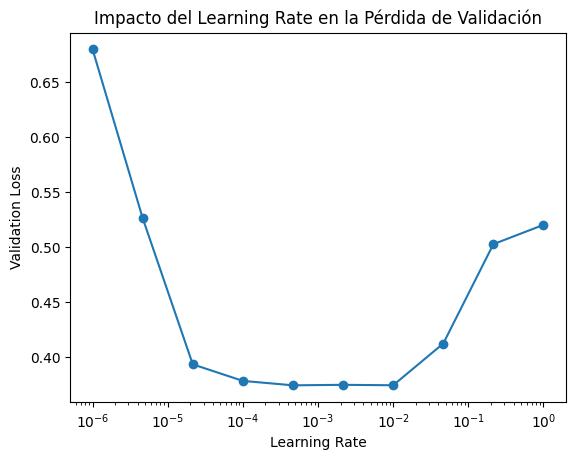

In [27]:
# Definir los valores de learning rate en una escala logarítmica
lr_values = np.logspace(-6, 0, num=10)

# Array para almacenar las métricas de pérdida de validación
loss_metric_array = []

# Re-inicializar el modelo para asegurar que se entrena desde cero
model = Sequential([
  Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  Dropout(0.5),  # 50% de Dropout
  Dense(32, activation='relu'),
  Dropout(0.5),  # 50% de Dropout
  Dense(1, activation='sigmoid')  # Capa de salida
])

# Loop para entrenar el modelo con diferentes learning rates
for lr in lr_values:
    # Compilar el modelo con el learning rate actual
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) # * Modificado para mi Macbook M1
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['AUC'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                        verbose=0)  # Usar verbose=0 para menos salida durante el entrenamiento

    # Almacenar la pérdida de validación mínima alcanzada para el learning rate actual
    min_val_loss = min(history.history['val_loss'])
    loss_metric_array.append((lr, min_val_loss))
    reinitialize_model(model)

# Gráfico para visualizar la relación entre learning rate y pérdida de validación
lr, val_losses = zip(*loss_metric_array)
plt.plot(lr, val_losses, '-o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Impacto del Learning Rate en la Pérdida de Validación')
plt.show()

In [28]:
# Asumiendo que loss_metric_array contiene pares de (learning rate, pérdida de validación mínima)
lr, val_losses = zip(*loss_metric_array)

# Encontrar el índice del valor mínimo de pérdida de validación
min_loss_index = val_losses.index(min(val_losses))

# Encontrar el learning rate correspondiente al mínimo de pérdida de validación
best_lr = lr[min_loss_index]

print(f"El learning rate con la menor pérdida de validación es: {best_lr} con una pérdida de: {val_losses[min_loss_index]}")

El learning rate con la menor pérdida de validación es: 0.00046415888336127773 con una pérdida de: 0.3746713697910309


# Preprocesado de variables categóricas

Vamos a construir un modelo con las variables categóricas. Comencemos generando variables one hot para poder alimentar un modelo con ellas.

In [ ]:
 # TODO - El profesor en vez de hacer get_dummies utilizo el OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=100).fit(pd_train[CATEGORICAL_COLUMNS])
X_categorical_train = ordinal_encoder.transform(pd_train[CATEGORICAL_COLUMNS])
X_categorical_test = ordinal_encoder.transform(pd_test[CATEGORICAL_COLUMNS])

**OrdinalEncoder**

The OrdinalEncoder transforms categorical features to ordinal integer values. This means each unique category value is assigned an integer value. For example, if you have a feature with three categories like 'low', 'medium', and 'high', these could be encoded as 0, 1, and 2, respectively.

The code snippet for OrdinalEncoder includes parameters handle_unknown="use_encoded_value" and unknown_value=100. This means that if the encoder encounters a category in the test data that wasn't present in the training data, it will assign it an encoded value of 100 instead of raising an error. This is particularly useful in situations where the test data may contain new, unseen categories.

In [ ]:

# TODO - 
onehot_encoder = OneHotEncoder(handle_unknown="ignore").fit(pd_train[CATEGORICAL_COLUMNS])
X_categorical_onehot_train = onehot_encoder.transform(pd_train[CATEGORICAL_COLUMNS]).toarray()
X_categorical_onehot_test = onehot_encoder.transform(pd_test[CATEGORICAL_COLUMNS]).toarray()

**OneHotEncoder**

The OneHotEncoder, on the other hand, converts categorical values into a format called "one-hot encoding". For each unique category value, a new binary column is created. Only one of these columns contains a 1 (indicating the presence of that category), and the rest contain 0s. This encoding is useful for categorical variables where no ordinal relationship exists between the categories.

Using handle_unknown='ignore' with OneHotEncoder ensures that if a category that wasn't seen during training appears in the test data, it will be ignored (resulting in a row of 0s for all the one-hot encoded columns for that category) instead of causing an error.

In [29]:
df_encoded = pd_data.copy()
df_encoded = pd.get_dummies(df_encoded, columns=CATEGORICAL_COLUMNS)
df_encoded['income_binary'] = df_encoded['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
df_encoded = df_encoded.drop('income', axis=1)

df_encoded.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income_binary,workclass_ ?,workclass_ Local-gov,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_default,race_ Black,race_ White,race_default,sex_ Female,sex_ Male,native-country_ United-States,native-country_default
17870,23,53245,13,0,1602,12,0,False,False,True,...,False,False,False,False,True,False,False,True,True,False
11102,36,99146,9,0,0,45,1,False,False,True,...,False,False,False,False,True,False,False,True,True,False
21667,41,168071,9,0,0,45,0,False,True,False,...,True,False,False,False,True,False,False,True,True,False
23146,28,36601,10,0,0,35,0,False,False,True,...,False,True,False,False,True,False,True,False,True,False
20563,62,378239,14,0,0,2,1,True,False,False,...,False,False,False,False,True,False,False,True,True,False


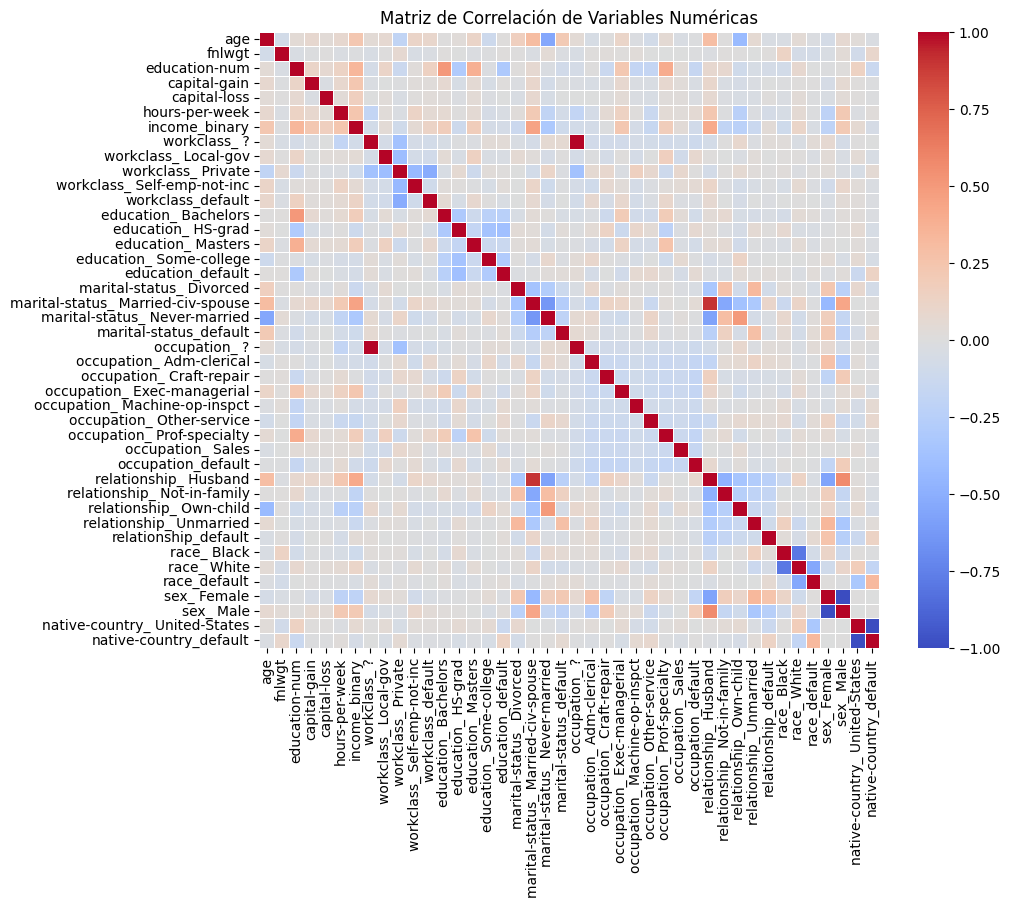

In [30]:
# Calcular la matriz de correlación de las variables numéricas
correlation_matrix = df_encoded.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Generar un mapa de calor para la matriz de correlación
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

De las variables a continuación, podemos observar que las que más estan correlacionadas con income_binary son:

*   Education-num
*   Marital-status - Married-civ-spouse

# Modelo baseline de todas las variables

Vuelva a realizar un modelo de regresión logística usando las variables categóricas.

In [31]:
# Separate numerical and categorical variables
numerical_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_encoded.select_dtypes(include=['object', 'bool']).columns  # Assuming your dummies are bool types

df_numerical = df_encoded[numerical_cols]
df_target = df_numerical['income_binary']
df_categorical = df_encoded[categorical_cols]

# Convert boolean values to numerical (1/0) for categorical variables
df_categorical_numerical = df_categorical.astype(int)
df_numerical.head()

scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical.iloc[: ,:5]), columns=df_numerical.iloc[: ,:5].columns)


df_final = pd.concat([df_numerical_scaled, df_target.reset_index(drop=True), df_categorical_numerical.reset_index(drop=True)], axis=1)
df_final.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,income_binary,workclass_ ?,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-not-inc,...,relationship_ Own-child,relationship_ Unmarried,relationship_default,race_ Black,race_ White,race_default,sex_ Female,sex_ Male,native-country_ United-States,native-country_default
0,-1.153796,-1.333941,1.128822,-0.152707,4.006418,0,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
1,-0.203508,-0.890586,-0.417721,-0.152707,-0.201316,1,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
2,0.161988,-0.224843,-0.417721,-0.152707,-0.201316,0,0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
3,-0.788300,-1.494704,-0.031086,-0.152707,-0.201316,0,0,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,1.697068,1.805159,1.515457,-0.152707,-0.201316,1,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In [32]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
X = df_final.drop('income_binary', axis=1)  # Características normalizadas
y = df_encoded['income_binary']  # Target ya transformado a binario

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Full dataset - Logistic Regression accuracy:")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nf1-score: {f1}\nroc_auc: {roc_auc}")
print("\n\n")
print("Numerical dataset - Logistic Regression accuracy:")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"F1-score: {f1_baseline:.4f}")
print(f"AUC-ROC: {roc_auc_baseline:.4f}")
print("\n\n")
print("""Podemos observar mejoramientos destacables a través de todas las metricas,
concluyendo que las variables categoricas si que tienen una contribución signficativa al modelo.""")

Full dataset - Logistic Regression accuracy:
Accuracy: 0.862
Precision: 0.7208121827411168
Recall: 0.6311111111111111
f1-score: 0.6729857819905213
roc_auc: 0.7800716845878137



Numerical dataset - Logistic Regression accuracy:
Accuracy: 0.8290
Precision: 0.6824
Recall: 0.4489
F1-score: 0.5416
AUC-ROC: 0.6941



Podemos observar mejoramientos destacables a través de todas las metricas,
concluyendo que las variables categoricas si que tienen una contribución signficativa al modelo.



---



# Modelo Deep Learning con todas las variables


## Construcción del modelo
Construye el modelo con Keras. Aunque hay muchas maneras de hacerlo, se recomienda construir un modelo que tenga una entrada para las variables numéricas y otra entrada por cada una de las variables categóricas.

Cada variable categórica debe "enganchar" con una capa de Embedding, de forma que cada variable se transforme en un vector de dimensión D (puede elegir el valor de D, o incluso hacer que varíe según la variable en cuestión). Así debe finalizar teniendo un tensor asociado a cada una de las features.

Una los tensores en uno solo usando alguna capa de Merge (Concatenación, Media ...) Finalmente, aplique varias capas ocultas estudiando varias posibilidades.

In [33]:
len(X.select_dtypes(include=['float64']).columns)

5

In [34]:
# Inputs
input_numerical = Input(shape=(5,), name='numerical_input')
input_categorical = Input(shape=((len(X.columns) - 5),), name='categorical_input') # * Had problems with the dummies

# Categorical path with embedding and regularization
x_categorical = Embedding(input_dim=(len(X.columns) - 5), output_dim=10, embeddings_regularizer=l2(0.001), name="embedding_categorical")(input_categorical)
x_categorical = Flatten(name="flat_vector")(x_categorical)
x_categorical = BatchNormalization()(x_categorical)

# Numerical path with additional layers
x_numeric = Dense(10, activation="relu", name="encoding_numerical")(input_numerical)
x_numeric = BatchNormalization()(x_numeric)

# Merge and final layers
x = Concatenate()([x_numeric, x_categorical])
x = Dense(10, activation="relu")(x)
x = Dropout(0.3)(x)  # Adjusted dropout rate
x = Dense(1, activation="sigmoid")(x)

# Model
model = Model([input_numerical, input_categorical], x, name='model_with_two_inputs')
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary(line_length=150)

Model: "model_with_two_inputs"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 categorical_input (InputLayer)              [(None, 35)]                                 0              []                                           
                                                                                                                                                      
 numerical_input (InputLayer)                [(None, 5)]                                  0              []                                           
                                                                                                                                                      
 embedding_categorical (Embedding)           (None, 35, 10)    

## Compilación del modelo
Compile el modelo con adam como función de optimización. Elija la función de pérdida acorde con el objetivo que buscamos. Además, elija algunas métricas que nos permitan evaluar el modelo.

In [35]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="area_under_curve")])

## Entrenamiento

Entrene el modelo. Elija el tamaño del batch y el número de épocas necesario.

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit({"numerical_input": X_train.iloc[:, :5], "categorical_input": X_train.iloc[:, 5:]}, y_train,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/200


100/100 [==============================] - 1s 3ms/step - loss: 0.4529 - accuracy: 0.7800 - area_under_curve: 0.8127 - val_loss: 0.4673 - val_accuracy: 0.7862 - val_area_under_curve: 0.8386
Epoch 2/200
100/100 [==============================] - 0s 1ms/step - loss: 0.3855 - accuracy: 0.8241 - area_under_curve: 0.8640 - val_loss: 0.4360 - val_accuracy: 0.7925 - val_area_under_curve: 0.8459
Epoch 3/200
100/100 [==============================] - 0s 2ms/step - loss: 0.3649 - accuracy: 0.8363 - area_under_curve: 0.8804 - val_loss: 0.4034 - val_accuracy: 0.8087 - val_area_under_curve: 0.8629
Epoch 4/200
100/100 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8372 - area_under_curve: 0.8787 - val_loss: 0.3584 - val_accuracy: 0.8425 - val_area_under_curve: 0.8898
Epoch 5/200
100/100 [==============================] - 0s 1ms/step - loss: 0.3510 - accuracy: 0.8416 - area_under_curve: 0.8888 - val_loss: 0.3371 - val_accuracy: 0.8600 - val_area_under_curve: 0.8974
Epoch 6

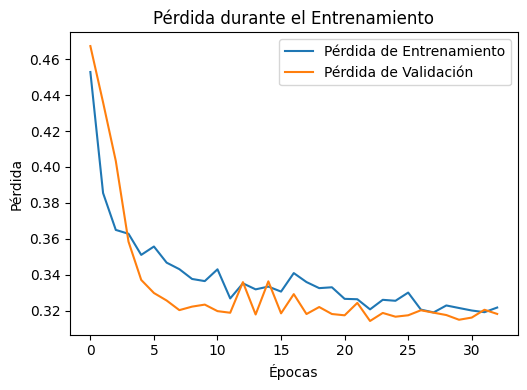

In [37]:
# Suponiendo que 'history' es el objeto retornado por model.fit()
metrics = history.history

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['loss'], label='Pérdida de Entrenamiento')
plt.plot(metrics['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Se ha decidido que el número de Epochs apropiado es de 27**

In [38]:
model.fit({"numerical_input": X_train.iloc[:, :5], "categorical_input": X_train.iloc[:, 5:]}, y_train, batch_size=32, epochs=40, verbose=2, validation_split=0.2)

Epoch 1/40
100/100 - 0s - loss: 0.3185 - accuracy: 0.8528 - area_under_curve: 0.9085 - val_loss: 0.3196 - val_accuracy: 0.8413 - val_area_under_curve: 0.8982 - 162ms/epoch - 2ms/step
Epoch 2/40
100/100 - 0s - loss: 0.3218 - accuracy: 0.8594 - area_under_curve: 0.9059 - val_loss: 0.3257 - val_accuracy: 0.8413 - val_area_under_curve: 0.8980 - 136ms/epoch - 1ms/step
Epoch 3/40
100/100 - 0s - loss: 0.3234 - accuracy: 0.8475 - area_under_curve: 0.9055 - val_loss: 0.3148 - val_accuracy: 0.8525 - val_area_under_curve: 0.9029 - 138ms/epoch - 1ms/step
Epoch 4/40
100/100 - 0s - loss: 0.3181 - accuracy: 0.8506 - area_under_curve: 0.9095 - val_loss: 0.3189 - val_accuracy: 0.8462 - val_area_under_curve: 0.9021 - 139ms/epoch - 1ms/step
Epoch 5/40
100/100 - 0s - loss: 0.3225 - accuracy: 0.8472 - area_under_curve: 0.9053 - val_loss: 0.3188 - val_accuracy: 0.8413 - val_area_under_curve: 0.9003 - 154ms/epoch - 2ms/step
Epoch 6/40
100/100 - 0s - loss: 0.3251 - accuracy: 0.8547 - area_under_curve: 0.9054 

Training Metrics: 
* Accuracy: 84.5%
* AUC: 90.25%

## Evaluación

Utilice el dataset de test para conseguir las métricas que se calcularon con el modelo baseline. Compare los resultados con el baseline.

In [39]:
# Predecir en el conjunto de prueba
X_test_numerical = X_test.iloc[:, :5]
X_test_categorical = X_test.iloc[:, 5:]


test_loss, test_accuracy, test_auc = model.evaluate(
    {"numerical_input": X_test_numerical, "categorical_input": X_test_categorical},
    y_test
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test AUC: {test_auc}")


32/32 [==============================] - 0s 815us/step - loss: 0.3183 - accuracy: 0.8420 - area_under_curve: 0.8980
Test Loss: 0.3183493912220001, Test Accuracy: 0.8420000076293945, Test AUC: 0.8979871273040771


## Representación Final de la Práctica: 

| Modelo | Accuracy | AUC |
|:-------------|:--------------:|--------------:|
| Regresión (Dataset Numérico)        | 80.2%           | 66.58%         |
| Regresión (Dataset Completo)        | 84.9%           | 76.64%         |
| Red Neuronal (Dataset Numérico)     | 85.14%           | ---           |
| Red Neuronal (Dataset Completo)     | 86.5%           | 90.84%         |